예제 7.5 주가 예측

In [ ]:
# 예제 7.5 주가 예측

# finance-datareader 설치
!pip install finance-datareader

In [ ]:
# 셋업
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import timeseries_dataset_from_array
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋 준비
df = fdr.DataReader('005930', '2010-01-01', '2023-12-31')   # 삼성전자

In [ ]:
# 상위 데이터 출력
df.head(3)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114


In [ ]:
# mplfinance 설치
!pip install mplfinance

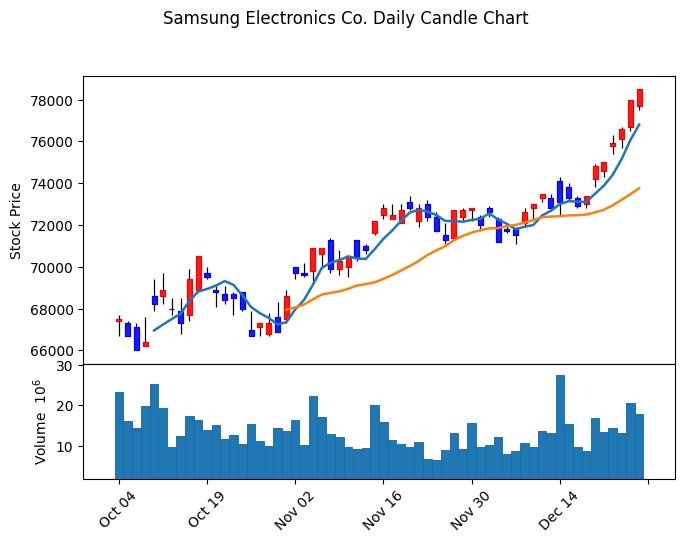

In [ ]:
# 일봉 차트
import mplfinance as mpf

candle_df = df['2023-10-01':'2023-12-31']

mc = mpf.make_marketcolors(up='red', down='blue', edge='inherit')
style = mpf.make_mpf_style(marketcolors=mc)

mpf.plot(candle_df,
         type='candle',      # 캔들 차트
         mav=(5, 20),        # 이동 평균선 5/20일
         volume=True,        # 거래량 표시
         style=style,        # 색상 지정
         figratio=(10, 7),   # 가로/세로 크기 지정
         title='Samsung Electronics Co. Daily Candle Chart',
         ylabel='Stock Price')

In [ ]:
# 불필요한 컬럼 제거
df = df.drop('Change', axis=1)

In [ ]:
# 정규화
min = df.min()
max = df.max()

stock_df = (df - min) / (max - min)

In [ ]:
# 시퀀스 데이터셋 준비
sequence_length = 3                    # 3일간의 데이터 입력
offset = 1                             # 다음 날 주가 예측
shift = sequence_length + offset - 1   # 레이블 위치

train_ds = timeseries_dataset_from_array(   # 학습 데이터셋
    data=stock_df['2010-01':'2021-12'].to_numpy()[:-shift],
    targets=stock_df['Close']['2010-01':'2021-12'].to_numpy()[shift:],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=False)

valid_ds = timeseries_dataset_from_array(   # 검증 데이터셋
    data=stock_df['2022-01':'2022-12'].to_numpy()[:-shift],
    targets=stock_df['Close']['2022-01':'2022-12'].to_numpy()[shift:],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=False)

test_ds = timeseries_dataset_from_array(   # 테스트 데이터셋
    data=stock_df['2023-01':'2023-12'].to_numpy()[:-shift],
    targets=stock_df['Close']['2023-01':'2023-12'].to_numpy()[shift:],
    sequence_length=sequence_length,
    batch_size=32,
    shuffle=False)

for inputs, targets in train_ds.take(1):
  print(inputs.shape)    # 입력 shape 확인
  print(targets.shape)   # 레이블 shape 확인

(32, 3, 5)
(32,)


In [ ]:
# 모델 생성
model = Sequential([
    LSTM(8, return_sequences=True,
         input_shape=(sequence_length, 5)),   # 입력 특징 5개
    LSTM(8),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 8)              448       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 1001 (3.91 KB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # 모니터링 지표 지정
    patience=3)           # 허용 범위 지정

history = model.fit(train_ds, epochs=50, verbose=0,
                    validation_data=valid_ds,
                    callbacks=early_stopping)

8/8 [==============================] - 0s 12ms/step


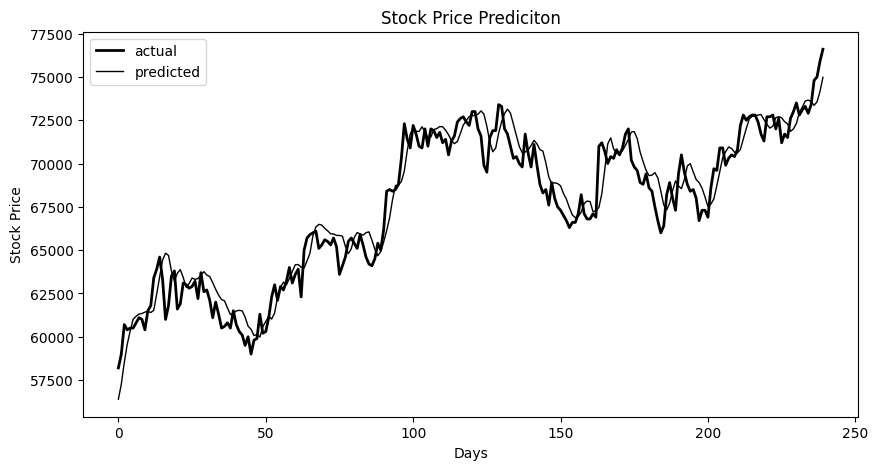

In [ ]:
# 예측 결과 시각화
max_C = df['Close'].max()   # 종가의 최대값
min_C = df['Close'].min()   # 종가의 최소값

y_pred = model.predict(test_ds)
y_pred = y_pred * (max_C - min_C) + min_C

y_test = []
for _, targets in test_ds:
    y_test.extend(targets)
y_test = np.array(y_test) * (max_C - min_C) + min_C

plt.figure(figsize=(10, 5))

plt.plot(y_test, label='actual', color='black', linewidth=2)
plt.plot(y_pred, label='predicted', color='black', linewidth=1)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediciton')
plt.legend()

plt.show()